In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/pytorch-image-dataloader/pytorch-image-dataloader.zip
!unzip -qq pytorch-image-dataloader.zip
%cd pytorch-image-dataloader

--2023-10-25 02:25:08--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/pytorch-image-dataloader/pytorch-image-dataloader.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.177.170, 52.92.227.2, 3.5.82.14, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.177.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 957931 (935K) [application/zip]
Saving to: ‘pytorch-image-dataloader.zip’

pytorch-image-datal 100%[===================>] 935.48K  4.32MB/s    in 0.2s    

2023-10-25 02:25:08 (4.32 MB/s) - ‘pytorch-image-dataloader.zip’ saved [957931/957931]

/content/pytorch-image-dataloader


In [2]:
! wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
! tar xf flower_photos.tgz

--2023-10-25 02:25:16--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.207, 142.250.125.207, 142.250.136.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   242MB/s    in 0.9s    

2023-10-25 02:25:17 (242 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [3]:
# import the necessary packages
from torchvision.datasets import ImageFolder, MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import shutil
import os

In [4]:
class config:
    # specify path to the flowers and mnist dataset
    FLOWERS_DATASET_PATH = "flower_photos"
    MNIST_DATASET_PATH = "mnist"

    # specify the paths to our training and validation set
    TRAIN = "train"
    VAL = "val"

    # set the input height and width
    INPUT_HEIGHT = 128
    INPUT_WIDTH = 128

    # set the batch size and validation data split
    BATCH_SIZE = 8
    VAL_SPLIT = 0.1

In [9]:
def copy_images(imagePaths, folder):
	# check if the destination folder exists and if not create it
	if not os.path.exists(folder):
		os.makedirs(folder)

	# loop over the image paths
	for path in imagePaths:
		imageName = path.split(os.path.sep)[-1]
		label = path.split(os.path.sep)[-2]
		labelFolder = os.path.join(folder, label)

		# check to see if the label folder exists and if not create it
		if not os.path.exists(labelFolder):
			os.makedirs(labelFolder)

		# construct the destination image path and copy the current
		# image to it
		destination = os.path.join(labelFolder, imageName)
		shutil.copy(path, destination)

In [7]:
list(paths.list_images(config.FLOWERS_DATASET_PATH))[:5]

['flower_photos/roses/8622493424_877ae35ed7.jpg',
 'flower_photos/roses/2491600761_7e9d6776e8_m.jpg',
 'flower_photos/roses/4360743371_6238b36d8c_m.jpg',
 'flower_photos/roses/5402157745_a384f0583d_n.jpg',
 'flower_photos/roses/14810868100_87eb739f26_m.jpg']

In [11]:
imagePaths = list(paths.list_images(config.FLOWERS_DATASET_PATH))
np.random.shuffle(imagePaths)

valPathsLen = int(len(imagePaths) * config.VAL_SPLIT)
trainPathsLen = len(imagePaths) - valPathsLen

trainPaths = imagePaths[:trainPathsLen]
valPaths = imagePaths[trainPathsLen:]

copy_images(trainPaths, config.TRAIN)
copy_images(valPaths, config.VAL)

In [6]:
list(paths.list_images(config.FLOWERS_DATASET_PATH))[:5]

['flower_photos/roses/8622493424_877ae35ed7.jpg',
 'flower_photos/roses/2491600761_7e9d6776e8_m.jpg',
 'flower_photos/roses/4360743371_6238b36d8c_m.jpg',
 'flower_photos/roses/5402157745_a384f0583d_n.jpg',
 'flower_photos/roses/14810868100_87eb739f26_m.jpg']

In [13]:
from torchvision.transforms.functional import vflip
resize = transforms.Resize(size = (config.INPUT_HEIGHT,
                                   config.INPUT_WIDTH))

hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)

trainTransforms = transforms.Compose([resize, hFlip, vFlip, rotate,
	transforms.ToTensor()])
valTransforms = transforms.Compose([resize, transforms.ToTensor()])

In [15]:
trainDataset = ImageFolder(root = config.TRAIN,
                           transform=trainTransforms)
valDataset = ImageFolder(root=config.VAL,
                         transform=valTransforms)

In [16]:
trainDataLoader = DataLoader(trainDataset,
	batch_size=config.BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size=config.BATCH_SIZE)

In [17]:
trainBatch = next(iter(trainDataLoader))
valBatch = next(iter(valDataLoader))

In [18]:
def visualize_batch(batch, classes, dataset_type):
	# initialize a figure
	fig = plt.figure("{} batch".format(dataset_type),
		figsize=(config.BATCH_SIZE, config.BATCH_SIZE))

	# loop over the batch size
	for i in range(0, config.BATCH_SIZE):
		# create a subplot
		ax = plt.subplot(2, 4, i + 1)

		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		image = batch[0][i].cpu().numpy()
		image = image.transpose((1, 2, 0))
		image = (image * 255.0).astype("uint8")

		# grab the label id and get the label from the classes list
		idx = batch[1][i]
		label = classes[idx]

		# show the image along with the label
		plt.imshow(image)
		plt.title(label)
		plt.axis("off")

	# show the plot
	plt.tight_layout()
	plt.show()

[INFO] visualizing training batch...


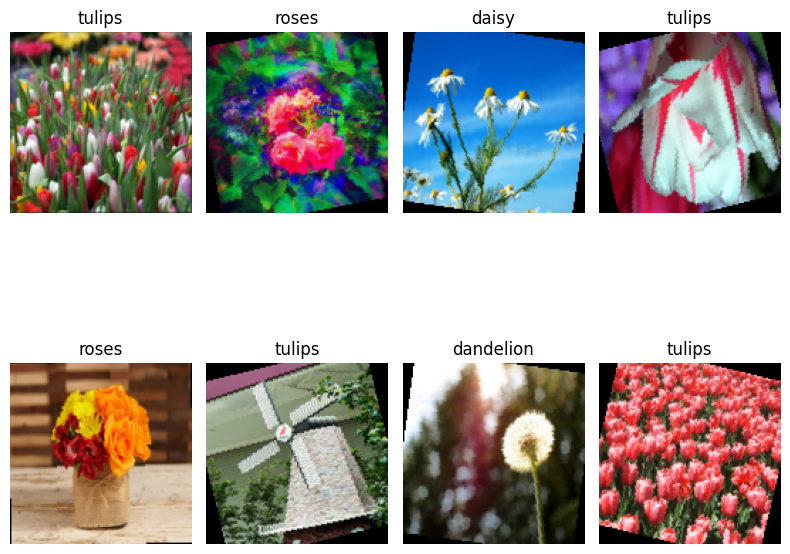

In [19]:
print("[INFO] visualizing training batch...")
visualize_batch(trainBatch, trainDataset.classes, "train")

In [20]:
# define the transform
transform = transforms.Compose([transforms.ToTensor()])

# initialize the training and validation dataset
print("[INFO] loading the training and validation dataset...")
trainDataset = MNIST(root=config.MNIST_DATASET_PATH, train=True,
	download=True, transform=transform)
valDataset = MNIST(root=config.MNIST_DATASET_PATH, train=False,
	download=True, transform=transform)

[INFO] loading the training and validation dataset...


100%|██████████| 9912422/9912422 [00:00<00:00, 27767084.56it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7013820.50it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 29338438.36it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13905495.45it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [21]:
print("[INFO] creating training and validation set dataloaders...")
trainDataLoader = DataLoader(trainDataset,
	batch_size=config.BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size=config.BATCH_SIZE)

[INFO] creating training and validation set dataloaders...


In [22]:
trainBatch = next(iter(trainDataLoader))
valBatch = next(iter(valDataLoader))

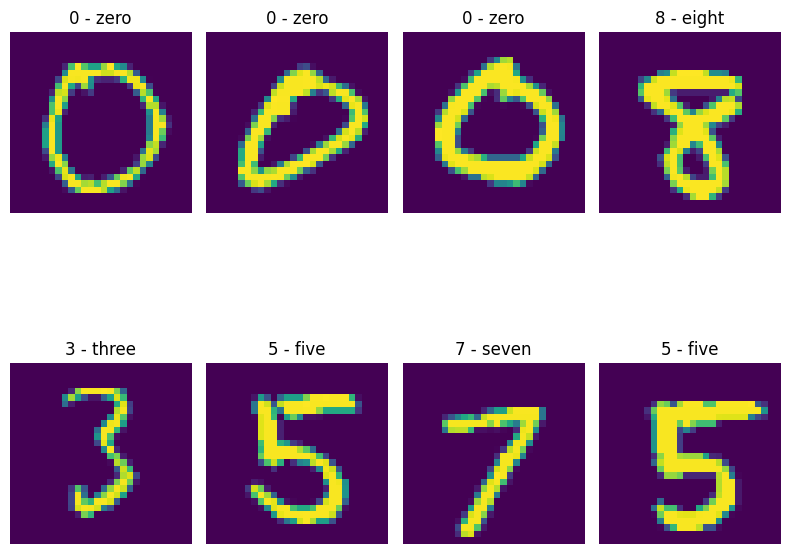

In [23]:
visualize_batch(trainBatch, trainDataset.classes, "train")